In [1]:
import json
import requests

import numpy as np
import pandas as pd

from datetime import datetime

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = 'test.csv'
data = pd.read_csv(path, index_col=None)
data.head(2)

,Transaction Time,Vendor SKU,Title,Item Name,Item Type,Units,Marketplace Currency,Sales Price (Marketplace Currency)
0,2020-01-31 23:57:21 PST,com.dominigames.mt9,Hidden Object - Mystery Tales: The Other Side,Hidden Object - Mystery Tales: The Other Side,Application,1,USD,0.0
1,2020-01-31 23:55:07 GMT,com.dominigames.christmas2,The Christmas Spirit: Mother Goose's Untold Tales,The Christmas Spirit: Mother Goose's Untold Tales,Application,1,GBP,0.0


In [3]:
data['tz'] = data["Transaction Time"].str.split(' ').str[-1]
data['datetime'] = data["Transaction Time"].str.split(' ').str[:2].str.join(" ")
data['datetime'] = pd.to_datetime(data['datetime'])

data['Vendor SKU'] = data['Vendor SKU'].str.replace('.unlock', '')

data['Item Type'] = data['Item Type'].replace({'Application':0, 'In-App':1})

data['date'] = data['datetime'].dt.date
data['dow'] = data['datetime'].dt.day_name()

In [4]:
repl = {1:'weekday', 2:'weekday', 3:'weekday', 4:'weekday', 5:'weekday', 6:'weekend', 7:'weekend'}
data['week'] = data['datetime'].dt.dayofweek.replace(repl)

In [5]:
data.head(2)

,Transaction Time,Vendor SKU,Title,Item Name,Item Type,Units,Marketplace Currency,Sales Price (Marketplace Currency),tz,datetime,date,dow,week
0,2020-01-31 23:57:21 PST,com.dominigames.mt9,Hidden Object - Mystery Tales: The Other Side,Hidden Object - Mystery Tales: The Other Side,0.0,1,USD,0.0,PST,2020-01-31 23:57:21,2020-01-31,Friday,weekday
1,2020-01-31 23:55:07 GMT,com.dominigames.christmas2,The Christmas Spirit: Mother Goose's Untold Tales,The Christmas Spirit: Mother Goose's Untold Tales,0.0,1,GBP,0.0,GMT,2020-01-31 23:55:07,2020-01-31,Friday,weekday


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79045 entries, 0 to 79044
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Transaction Time                    79045 non-null  object        
 1   Vendor SKU                          79017 non-null  object        
 2   Title                               79017 non-null  object        
 3   Item Name                           79017 non-null  object        
 4   Item Type                           79017 non-null  float64       
 5   Units                               79045 non-null  int64         
 6   Marketplace Currency                79045 non-null  object        
 7   Sales Price (Marketplace Currency)  79045 non-null  float64       
 8   tz                                  79045 non-null  object        
 9   datetime                            79045 non-null  datetime64[ns]
 10  date                  

In [7]:
# избавимся от "безымянных данных"
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79017 entries, 0 to 79044
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Transaction Time                    79017 non-null  object        
 1   Vendor SKU                          79017 non-null  object        
 2   Title                               79017 non-null  object        
 3   Item Name                           79017 non-null  object        
 4   Item Type                           79017 non-null  float64       
 5   Units                               79017 non-null  int64         
 6   Marketplace Currency                79017 non-null  object        
 7   Sales Price (Marketplace Currency)  79017 non-null  float64       
 8   tz                                  79017 non-null  object        
 9   datetime                            79017 non-null  datetime64[ns]
 10  date                  

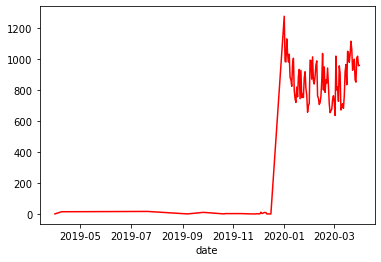

In [8]:
plt.figure()
data.groupby(['date']).size().plot(color='r')

Т.к. интересные данные начинаются только с 2020г, принято решение избавиться от днных за 2019г.

In [9]:
# type(data['date']), type(datetime.strptime('2020-01-01', "%Y-%m-%d"))
data = data[data['datetime']>=datetime.strptime('2020', "%Y")]

In [10]:
data['date'].min()

datetime.date(2020, 1, 1)

In [11]:
KEY = ''
res = requests.get(f'https://openexchangerates.org/api/latest.json?app_id={KEY}')
res

<Response [200]>

In [12]:
res = json.loads(res.text)
rates = pd.DataFrame({'Marketplace Currency':list(res['rates'].keys()), 'rates':list(res['rates'].values())})
data = data.merge(rates, on='Marketplace Currency')
data['Sales Price USD'] = data['Sales Price (Marketplace Currency)'] / data['rates']

## Основное задание

In [13]:
min_date = datetime.fromisoformat('2020-01-15')
max_date = datetime.fromisoformat('2020-02-15')

df = data[(data['datetime']>=min_date) & (data['datetime']<=max_date)]

In [14]:
df_item = df.groupby(['Vendor SKU', 'Item Type']).size().reset_index(name='Count item')
total_income = df[df['Item Type']==1].groupby(['Vendor SKU'])['Sales Price USD'].sum().reset_index(name='Total income')

# Переопределяем поле Title в список названий входящих в Vendor SKU
names = df.groupby(['Vendor SKU'])['Title'].apply(list).reset_index()
names['Title'] = names['Title'].apply(lambda x: np.unique(np.array(x))).str.join(', ')

df = names.merge(df_item[df_item['Item Type']==1][['Vendor SKU', 'Count item']].rename(columns={'Count item':'Count In-App'}), on='Vendor SKU')
df = df.merge(df_item[df_item['Item Type']==0][['Vendor SKU', 'Count item']].rename(columns={'Count item':'Count Application'}), on='Vendor SKU')
df = df.merge(total_income, on='Vendor SKU')
              
del df_item, total_income, names

df.head()

,Vendor SKU,Title,Count In-App,Count Application,Total income
0,com.dominigames.cc7,Labyrinths Of The World: A Dangerous Game,78,513,284.929956
1,com.dominigames.cc8,Labyrinths Of The World: When Worlds Collide,559,1909,1526.844316
2,com.dominigames.ch3,Hidden Objects - The Christmas Spirit: Grimm T...,242,3907,757.074567
3,com.dominigames.christmas,The Christmas Spirit: Trouble in Oz,75,1186,251.005317
4,com.dominigames.christmas2,The Christmas Spirit: Mother Goose's Untold Tales,53,683,175.491741


In [15]:
df['Total income'] = df['Total income'].round(1)
df.rename(columns={'Total income': 'Total income USD'}, inplace=True)

df.to_excel('Task.xlsx', index=None)

## Творческое задание

#### График загрузок и покупок

Text(0, 0.5, 'Units')

<Figure size 432x288 with 0 Axes>

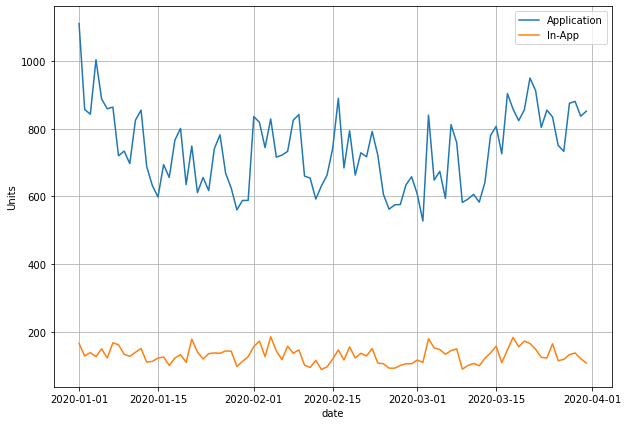

In [16]:
plt.figure()

df = data[data['Item Type']==0].groupby('date')['Vendor SKU'].size()
df2 = data[data['Item Type']==1].groupby('date')['Vendor SKU'].size()

df = pd.concat([df, df2], axis=1, )
df.columns=['Application', 'In-App']

df.plot(figsize=(10,7), grid=True)
    
plt.ylabel("Units")

Из графика видно, что кол-во загрузок в разы превышают кол-во покупок. Так же видим пик установок приходящийся на новогодние каникулы, а так же с середины марта (предположительно из-за пандемии коронавируса и домашней изоляции спрос вырос). Попробуем нормализовать данные

<Figure size 432x288 with 0 Axes>

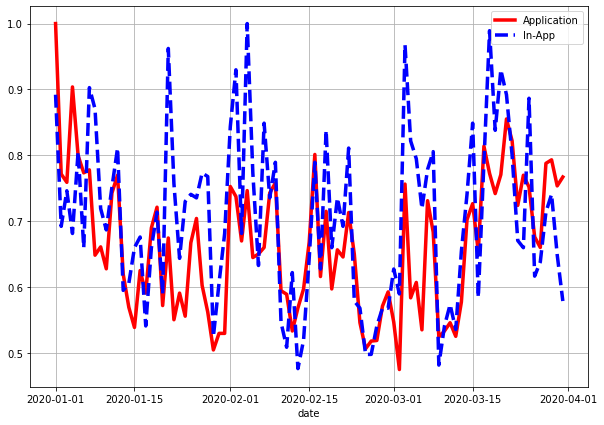

In [17]:
plt.figure()

df['Application'] = df['Application']/df['Application'].max()
df['In-App'] = df['In-App']/df['In-App'].max()

df.plot(figsize=(10,7), grid=True, style=['r-','b--'], linewidth=3.5)

График нам показывает, что покупки игр могут быть совершены не обязательно в этот же день.

Далее, можем посмотреть сколько и в какие дни недели совершались установки и покупки игр.

<Figure size 432x288 with 0 Axes>

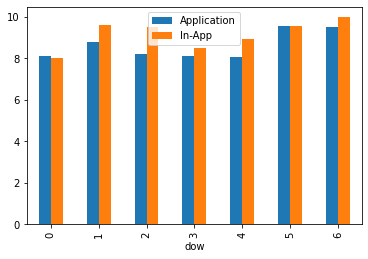

In [18]:
plt.figure()
df_per_dow = df.reset_index()
df_per_dow['dow'] = pd.to_datetime(df_per_dow['date']).dt.dayofweek
# day_name()
df_per_dow = df_per_dow.groupby(['dow']).sum().sort_index()
df_per_dow.plot.bar()

По графику не видим отчетливой зависимости кол-ва покупок и установок от дней недели, но все же, уверенно чувствуют себя столбцы приходящиеся на субботу и воскресенье (5-ый и 6-ой). Далее взглянем на сами игры.

In [19]:
data.head(2)

,Transaction Time,Vendor SKU,Title,Item Name,Item Type,Units,Marketplace Currency,Sales Price (Marketplace Currency),tz,datetime,date,dow,week,rates,Sales Price USD
0,2020-01-31 23:57:21 PST,com.dominigames.mt9,Hidden Object - Mystery Tales: The Other Side,Hidden Object - Mystery Tales: The Other Side,0.0,1,USD,0.00,PST,2020-01-31 23:57:21,2020-01-31,Friday,weekday,1.0,0.00
1,2020-01-31 23:51:01 PST,com.dominigames.dr8,Dark Romance: Winter Lily Collector's Edition,Unlock,1.0,1,USD,2.99,PST,2020-01-31 23:51:01,2020-01-31,Friday,weekday,1.0,2.99


In [20]:
data['Vendor SKU'].nunique(), data['Title'].nunique(), len(data)

(47, 36, 78893)